# Projekt 4: Generalna ocena jakości modeli przestrzennych RNA

## Naming:
- atom --> linijka w pliku pdb
- structure (nukleotyd) --> zestaw 20-23 linijek w pdb (identyfikowany np "A 1") + jedna linijka w tor
- model --> zbiór structures znajdujący się w katalogu (identyfikowany np "1_solution_0_rpr_A_3_G")

## TODO
- [x] add parsing and concatenation to all nucleotides (lines in pbd file)  of a data point
- [x] concatenate both feature formats (pbd and tor) to one vector
- [ ] apply padding in nn input to max no of nucleotides (lines in pbd files)
- [ ] apply holdout to nn training (instead of x,y)
- [ ] normalize data
- [ ] change how nan values are treated
- [ ] "stratify" holdout sets to fairly distribute all 10 models
- [ ] implement model training pipeline to follow training loop
- [ ] test out models

In [4]:
# %pip install pandas biopython joblib scikit-learn

In [5]:
import os
import xml.etree.ElementTree as ET
from pathlib import Path

import numpy as np
import pandas as pd
from Bio.PDB import PDBParser
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split

1. Zapoznanie się z udostępnionymi zbiorami danych i ewentualne przetransformowanie ich do postaci ułatwiającej zastosowanie technik sztucznej inteligencji np. integracja danych składowych przechowywanych w różnych formatach z wykorzystaniem jednej spójnej reprezentacji.

In [6]:
DATASET_PATH = Path("./resources/datasets/RNA-Puzzles")

challenges = [f"pz{index:02}" for index in range(1, 11)]

In [7]:
def parse_motifs(challenges: list[str]) -> pd.DataFrame:
    result_df = pd.DataFrame()
    for challenge in challenges:
        current_df = pd.read_csv(
            DATASET_PATH / f"{challenge}/filter-results.txt",
            sep="\t",
            header=None,
            names=[
                "filename",
                "number_of_segments",
                "number_of_residues",
                "nucleotide_ranges",
                "sequences",
            ],
        )
        current_df["challenge_number"] = challenge
        result_df = pd.concat([result_df, current_df])

    # UWAGA! Warto ograniczyć analizy do motywów strukturalnie złożonych składających się z przynajmniej dwóch,
    # a najlepiej trzech lub więcej segmentów.
    result_df = result_df[result_df["number_of_segments"] >= 3]
    return result_df.reset_index(drop=True)


motifs = parse_motifs(challenges)
motifs

filename  number_of_segments  number_of_residues  \
0           1_solution_0_rpr_A_4_C                   3                  20   
1           1_solution_0_rpr_A_5_C                   3                  23   
2           1_solution_0_rpr_A_6_G                   3                  24   
3           1_solution_0_rpr_A_7_C                   3                  24   
4           1_solution_0_rpr_A_8_G                   3                  24   
..                             ...                 ...                 ...   
673  10_0_solution_4LCK_rpr_B_55_C                   3                  32   
674  10_0_solution_4LCK_rpr_B_56_G                   3                  38   
675  10_0_solution_4LCK_rpr_B_57_A                   4                  42   
676  10_0_solution_4LCK_rpr_B_58_A                   4                  43   
677  10_0_solution_4LCK_rpr_B_59_U                   4                  36   

                      nucleotide_ranges  \
0               A1-A8, B10-B16, B19-B23   
1                A1-A9, B8-B15, B18-B23   
2               A2-A10, B7-B14, B17-B23   
3               A3-A11, B6-B13, B16-B22   
4               A4-A12, B5-B12, B15-B21   
..                                  ...   
673           A48-A63, B16-B21, B50-B59   
674           A48-A64, B15-B22, B49-B61   
675  A49-A54, A58-A64, B14-B22, B44-B63   
676   A59-A63, B6-B11, B13-B23, B43-B63   
677   B6-B10, B12-B22, B44-B52, B54-B64   

                                             sequences challenge_number  
0                             CCGCCGCG, CAUGCCU, GGCGG             pz01  
1                          CCGCCGCGC, GCCAUGCC, UGGCGG             pz01  
2                         CGCCGCGCC, CGCCAUGC, GUGGCGG             pz01  
3                         GCCGCGCCA, GCGCCAUG, UGUGGCG             pz01  
4                         CCGCGCCAU, CGCGCCAU, CUGUGGC             pz01  
..                                                 ...              ...  
673               AGGAUAGUGAAAGCUA, UGGUAG, GGGUUCGAAU             pz10  
674         AGGAUAGUGAAAGCUAG, GUGGUAGA, CGGGUUCGAAUCC             pz10  
675   GGAUAG, AAGCUAG, AGUGGUAGA, GGUCGCGGGUUCGAAUCCCG             pz10  
676  AGCUA, AGUAGU, CAGUGGUAGAA, GGGUCGCGGGUUCGAAUCCCG             pz10  
677         AGUAG, UCAGUGGUAGA, GGUCGCGGG, UCGAAUCCCGU             pz10  

[678 rows x 6 columns]

In [8]:
def parse_xml_file(file_path: Path) -> pd.DataFrame:
    tree = ET.parse(file_path)
    root = tree.getroot()
    return pd.DataFrame(
        [
            {
                "filename": child.find("description").find("filename").text,
                "score": child.find("score").text,
            }
            for child in root
        ]
    )


def parse_scores(motifs: pd.DataFrame) -> pd.DataFrame:
    result_df = pd.DataFrame()
    for index, row in motifs.iterrows():
        core_path = DATASET_PATH / f"{row['challenge_number']}"
        xml_path = core_path / f"{row['filename']}-rmsd.xml"

        if xml_path.exists():
            current_df = parse_xml_file(xml_path)
            current_df["solution_directory"] = row["filename"]
            current_df["dataset_files_path"] = core_path / (
                f"{row['filename']}/" + current_df["filename"].apply(lambda x: x[:-4])
            )
            result_df = pd.concat([result_df, current_df])
        else:
            motifs.drop(index, inplace=True)

    return result_df


scores = parse_scores(motifs)
scores

filename  score             solution_directory  \
0   1_bujnicki_1_rpr.pdb  4.769         1_solution_0_rpr_A_4_C   
1   1_bujnicki_2_rpr.pdb  4.594         1_solution_0_rpr_A_4_C   
2   1_bujnicki_3_rpr.pdb  3.921         1_solution_0_rpr_A_4_C   
3   1_bujnicki_4_rpr.pdb  4.522         1_solution_0_rpr_A_4_C   
4   1_bujnicki_5_rpr.pdb  4.616         1_solution_0_rpr_A_4_C   
..                   ...    ...                            ...   
21     10_DING_5_rpr.pdb  4.516  10_0_solution_4LCK_rpr_B_59_U   
22     10_DING_6_rpr.pdb  3.939  10_0_solution_4LCK_rpr_B_59_U   
23     10_DING_7_rpr.pdb  4.639  10_0_solution_4LCK_rpr_B_59_U   
24     10_DING_8_rpr.pdb   5.66  10_0_solution_4LCK_rpr_B_59_U   
25     10_DING_9_rpr.pdb  4.428  10_0_solution_4LCK_rpr_B_59_U   

                                   dataset_files_path  
0   resources/datasets/RNA-Puzzles/pz01/1_solution...  
1   resources/datasets/RNA-Puzzles/pz01/1_solution...  
2   resources/datasets/RNA-Puzzles/pz01/1_solution...  
3   resources/datasets/RNA-Puzzles/pz01/1_solution...  
4   resources/datasets/RNA-Puzzles/pz01/1_solution...  
..                                                ...  
21  resources/datasets/RNA-Puzzles/pz10/10_0_solut...  
22  resources/datasets/RNA-Puzzles/pz10/10_0_solut...  
23  resources/datasets/RNA-Puzzles/pz10/10_0_solut...  
24  resources/datasets/RNA-Puzzles/pz10/10_0_solut...  
25  resources/datasets/RNA-Puzzles/pz10/10_0_solut...  

[20956 rows x 4 columns]

In [9]:
# # find max number of atoms in all pdb files
# max_atoms = 0
# for row in scores.iterrows():

#     parser = PDBParser(QUIET=True)
#     structure = parser.get_structure("PDB_structure", f"{row[1].dataset_files_path}.pdb")
#     for model in structure:
#         for chain in model:
#             for residue in chain:
#                 n_atoms = len(residue)
#                 max_atoms = max(max_atoms, n_atoms)
# print(max_atoms)

In [23]:
def parse_pdb_file(file_path: Path) -> pd.DataFrame:
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("PDB_structure", f"{file_path}.pdb")

    pdb_data: list = []
    for model in structure:
        for chain in model:
            for residue in chain:
                coords_dict = {}
                for i, atom in enumerate(residue, start=1):
                    coords_dict[f"x_{i}"] = atom.coord[0]
                    coords_dict[f"y_{i}"] = atom.coord[1]
                    coords_dict[f"z_{i}"] = atom.coord[2]
                
                # padding
                pad_len = 23*3 # max no of atoms in all structures * 3
                if len(coords_dict) < pad_len:
                    for i in range(len(coords_dict)+3, pad_len+3):
                        coords_dict[f"x_{i//3}"] = np.nan
                        coords_dict[f"y_{i//3}"] = np.nan
                        coords_dict[f"z_{i//3}"] = np.nan

                pdb_dict = {
                    "chain_id": chain.id,
                    "residue_number": residue.id[1],
                    "residue_name": residue.resname,
                    **coords_dict
                }

                pdb_data.append(pdb_dict)

    return pd.DataFrame(pdb_data)


def parse_tor_file(file_path: Path) -> pd.DataFrame:
    result_df = pd.read_csv(f"{file_path}.tor", sep="\s+")
    result_df.replace("-", np.nan, inplace=True)
    result_df = result_df.rename(
        columns={
            "Chain": "chain_id",
            "ResNum": "residue_number",
            "Name": "residue_name",
            "iCode": "icode"
        }
    )
    return result_df

def parse_structures(file_path: Path, keep_ids: bool = False) -> pd.DataFrame:
    pdb_df = parse_pdb_file(file_path)
    tor_df = parse_tor_file(file_path)

    structures_df = pd.merge(pdb_df, tor_df, on=["chain_id", "residue_name", "residue_number"])
    # except Exception as e:
    #     print("bad file: ", file_path)
    #     raise e

    if not keep_ids:
        structures_df.drop(columns=["chain_id", "residue_number", "residue_name", "icode"], inplace=True)
    return structures_df

def get_model_festures_df(structures_df: pd.DataFrame) -> np.ndarray:
    # create a list of colnames that consists of structure_df.columns repeated 3 times
    # features_colnames = [f"{col}_atom_{i}" for col in structure_df.columns for i in range(structure_df.shape)]
    # print(len(features_colnames))
    features_df = pd.DataFrame(structures_df.values.flatten()).T
    structures_df.fillna(0, inplace=True)
    # print(structures_df.shape, features_df.shape)

    nucleotides_pad_length = 3952
    if features_df.shape[1] < nucleotides_pad_length:
        for i in range(features_df.shape[1], nucleotides_pad_length):
            features_df[i] = 0
    # print(structures_df.shape, features_df.shape)

    return features_df
    

2. Krótkie zapoznanie się z dostępnymi przestrzeniami reprezentacji struktur 3D RNA (przestrzenie kartezjańska i kątów torsyjnych) i ich formatami zapisu. Wybór obiecującej przestrzeni na której będziecie Państwo bazować wraz z uzasadnieniem.

In [11]:
example_path = scores["dataset_files_path"].values[0]
example_structure = parse_structures(example_path, keep_ids=True)
# print(example_structure.head())

# example_structure = get_structure_features(example_structure)
# print(example_structure.shape)
# example_structure

/tmp/ipykernel_19713/3410192127.py:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result_df.replace("-", np.nan, inplace=True)


3. Określenie procentowych progów pozwalających podzielić dostępny zbiór danych na część treningową, walidacyjną i ewaluacyjną. Czy rozmiar dostępnego zbioru jest wystarczający? Czy należy go rozbudować? Jeśli tak to w jaki sposób?

In [12]:
# train-validation-test splits -> 70-15-15
VALID_TEST_SIZE: float = 0.15
TRAIN_SIZE: float = 1 - (2 * VALID_TEST_SIZE)

assert TRAIN_SIZE > 0 and VALID_TEST_SIZE > 0

4. Określenie sposobu reprezentacji wiedzy, którą dysponujemy (tzn. wektora cech). Czy stosowane będą techniki identyfikacji najistotniejszych cech? Jeśli tak to jakie?

In [13]:
scores.head()

filename  score      solution_directory  \
0  1_bujnicki_1_rpr.pdb  4.769  1_solution_0_rpr_A_4_C   
1  1_bujnicki_2_rpr.pdb  4.594  1_solution_0_rpr_A_4_C   
2  1_bujnicki_3_rpr.pdb  3.921  1_solution_0_rpr_A_4_C   
3  1_bujnicki_4_rpr.pdb  4.522  1_solution_0_rpr_A_4_C   
4  1_bujnicki_5_rpr.pdb  4.616  1_solution_0_rpr_A_4_C   

                                  dataset_files_path  
0  resources/datasets/RNA-Puzzles/pz01/1_solution...  
1  resources/datasets/RNA-Puzzles/pz01/1_solution...  
2  resources/datasets/RNA-Puzzles/pz01/1_solution...  
3  resources/datasets/RNA-Puzzles/pz01/1_solution...  
4  resources/datasets/RNA-Puzzles/pz01/1_solution...

(array([ 80.,   0.,   0., 216.,  87., 130.,   0.,  52.,   0., 101.]),
 array([12., 16., 20., 24., 28., 32., 36., 40., 44., 48., 52.]),
 <BarContainer object of 10 artists>)

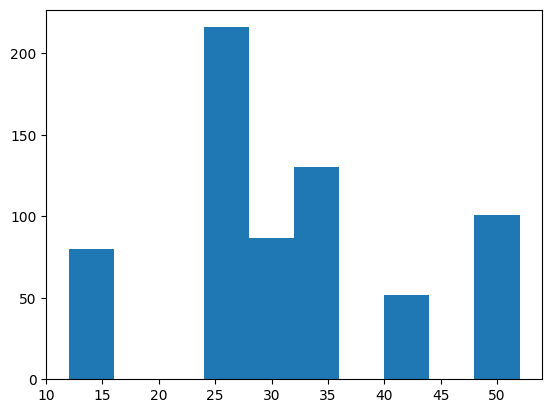

In [22]:
import matplotlib.pyplot as plt

plt.hist(scores["solution_directory"].value_counts())

In [24]:
REPRESENTATIONS_PATH = Path("./resources/datasets/representations")
STRUCTURE_DATASET_PATH = REPRESENTATIONS_PATH / "structure_dataset_test.csv"


def prepare_structures(scores: pd.DataFrame) -> pd.DataFrame:
    result_df = pd.DataFrame()
    for _, row in scores.iterrows():
        # print(row["dataset_files_path"], row.name)
        structure_df = get_model_festures_df(parse_structures(row["dataset_files_path"]))
        structure_df["target_score"] = row["score"]
        result_df = pd.concat([result_df, structure_df])
    return result_df


def parallel_processing(scores: pd.DataFrame) -> pd.DataFrame:
    cores = max(1, os.cpu_count() - 1)
    data_splits = np.array_split(scores, cores)
    fn = delayed(prepare_structures)
    results = Parallel(n_jobs=cores, verbose=10)(fn(data_split) for data_split in data_splits)
    return pd.concat(results)


def make_structure_dataset_csv(scores: pd.DataFrame) -> None:
    dataset = parallel_processing(scores)
    print(dataset.shape)
    dataset.to_csv(STRUCTURE_DATASET_PATH, index=None)

if not STRUCTURE_DATASET_PATH.exists():
    make_structure_dataset_csv(scores.iloc[100:110])

/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
/tmp/ipykernel_19713/287531414.py:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_19713/287531414.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_19713/287531

(23, 76) (1, 1748)
(23, 76) (1, 1748)
(23, 76) (1, 1748)
(23, 76) (1, 1748)
(23, 76) (1, 1748)
(23, 76) (1, 1748)
(23, 76) (1, 1748)


/tmp/ipykernel_19713/287531414.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_19713/287531414.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_19713/287531414.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_19713/287531414.py:72: PerformanceWarnin

(23, 76) (1, 3952)
(23, 76) (1, 1748)


/tmp/ipykernel_19713/287531414.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_19713/287531414.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_19713/287531414.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_19713/287531414.py:72: PerformanceWarnin

(23, 76) (1, 3952)
(23, 76) (1, 3952)
(23, 76) (1, 3952)
(23, 76) (1, 1748)
(23, 76) (1, 3952)
(23, 76) (1, 3952)
(23, 76) (1, 1748)


/tmp/ipykernel_19713/287531414.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_19713/287531414.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_19713/287531414.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_19713/287531414.py:72: PerformanceWarnin

(23, 76) (1, 3952)


/tmp/ipykernel_19713/287531414.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_19713/287531414.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_19713/287531414.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_19713/287531414.py:72: PerformanceWarnin

(23, 76) (1, 3952)
(23, 76) (1, 3952)
(23, 76) (1, 3952)


/tmp/ipykernel_19713/287531414.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_19713/287531414.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_19713/287531414.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_19713/287531414.py:72: PerformanceWarnin

(10, 3953)


[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    2.8s finished


In [18]:
REPRESENTATIONS_PATH = Path("./resources/datasets/representations")
STRUCTURE_DATASET_PATH = REPRESENTATIONS_PATH / "structure_dataset_test.csv"

structure_dataset = pd.read_csv(STRUCTURE_DATASET_PATH)
structure_dataset.shape

(10, 1749)

In [12]:
def preprocess_pdb_dataset(dataset: pd.DataFrame) -> tuple[np.array, np.array]:
    X = dataset.drop(dataset.columns[-1], axis=1)
    y = dataset[dataset.columns[-1]]
    return np.array(X), np.array(y)

def preprocess_structure_dataset(dataset: pd.DataFrame):
    # TODO
    return None

X, y = preprocess_pdb_dataset(structure_dataset)
X.shape, y.shape

((14057501, 3), (14057501,))

In [13]:
RANDOM_STATE: int = 42

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_valid, y_valid, test_size=0.5, random_state=RANDOM_STATE
)

print(
    f"""
    Train size: {X_train.shape} [{X_train.shape[0] / X.shape[0] * 100:.2f}%]
    Valid size: {X_valid.shape} [{X_valid.shape[0] / X.shape[0] * 100:.2f}%]
    Test  size: {X_test.shape} [{X_test.shape[0] / X.shape[0] * 100:.2f}%]
    """
)


    Train size: (9840250, 3) [70.00%]
    Valid size: (2108625, 3) [15.00%]
    Test  size: (2108626, 3) [15.00%]
    


5. Wybór obiecujących technik uczenia maszynowego, które uważacie Państwo, że powinny się sprawdzić podczas rozwiązywania postawionego problemu wraz z uzasadnieniem (np. głębokie sieci neuronowe, SVM, RandomForest ,itd.).

Największa ilość featurów = 76*52 = 3952

In [14]:
# dummy approach
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

regr = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
rf_score = root_mean_squared_error(y_test, y_pred)
rf_score

3.71125561825804

6. Iteracyjne przeprowadzenie procesu uczenia, określenie wartości parametrów kluczowych dla tego procesu (np. zastosowana funkcja straty, learning rate, optimizer, itd.) i wskazanie czy natrafiliście Państwo na jakieś problemy podczas tego procesu np. przeuczenie i jak Państwo sobie z tymi problemami poradziliście o ile rzeczywiście wystąpiły?

7. Optymalizacja wartości hiperparametrów – czy warto je optymalizować w przypadku rozpatrywanego problemu? Jeśli tak to w jaki sposób?

8. Wybór i uzasadnienie zastosowanych miar oceny, przeprowadzenie procesu ewaluacji uzyskanego(ych) modelu(i), podsumowanie i analiza uzyskanych wyników.